In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import butter, lfilter, filtfilt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [15,3]
plt.rcParams.update({'font.size' : 18})

In [ ]:
# Fungsi Plotting
def fig_from_df(df):
    fig = go.Figure()
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col))
    return fig

In [ ]:
# Import Data
data = pd.read_excel("https://github.com/AkbarFauzy/Datasets/blob/main/streets_sensor_2021-12-14_13-40-41.xls?raw=true")
# Menghilangkan Spasi pada nama kolom
data.columns = data.columns.str.replace(' ','_')

In [ ]:
# Set index
data = data.set_index("Time_(s)")

In [ ]:
Az= data["Linear_Acceleration_z_(m/s^2)"]
Ay= data["Linear_Acceleration_y_(m/s^2)"]
Ax= data["Linear_Acceleration_x_(m/s^2)"]

# Mengenolkan sinyal pada sumbu Y
Az = Az-(sum(Az)/len(Az))
Ay = Ay-(sum(Ay)/len(Ay))
Ax = Ax-(sum(Ax)/len(Ax))

data["Linear_Acceleration_z_(m/s^2)"] = Az
data["Linear_Acceleration_y_(m/s^2)"] = Ay
data["Linear_Acceleration_x_(m/s^2)"] = Ax

# Plot Raw Sinyal
fig = fig_from_df(data)
fig.write_html('time-history.html',full_html=False,include_plotlyjs='cdn')
fig.update_layout(
    title = "Raw Signal",
    xaxis_title = "Time (s)",
    yaxis_title = "Acc (m/s^2)"
)
fig.show()


In [ ]:
n = len(data) # Panjang Data
zfhat = np.fft.fft(data['Linear_Acceleration_z_(m/s^2)'], n) # Operasi FFT
zfhat[0] = 0 # removing DC
zPSD = zfhat * np.conj(zfhat) / n # Power Spectrum

freq = (1/(n/100)) * np.arange(n) # x - axis untuk Frequency
L = np.arange(1, np.floor(n/2), dtype='int')

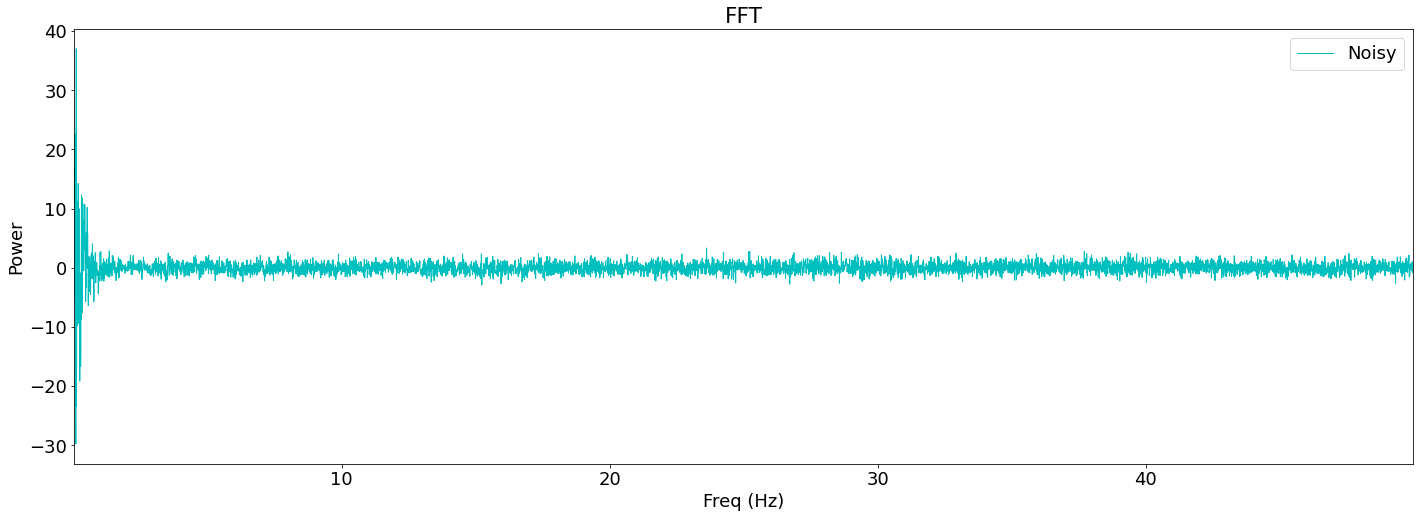

In [ ]:
plt.figure(figsize=(24,8))
plt.plot(freq, zfhat, color='c', LineWidth=1, label='Noisy')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.xlabel("Freq (Hz)")
plt.ylabel('Power')
plt.title('FFT')
plt.legend()
plt.show()

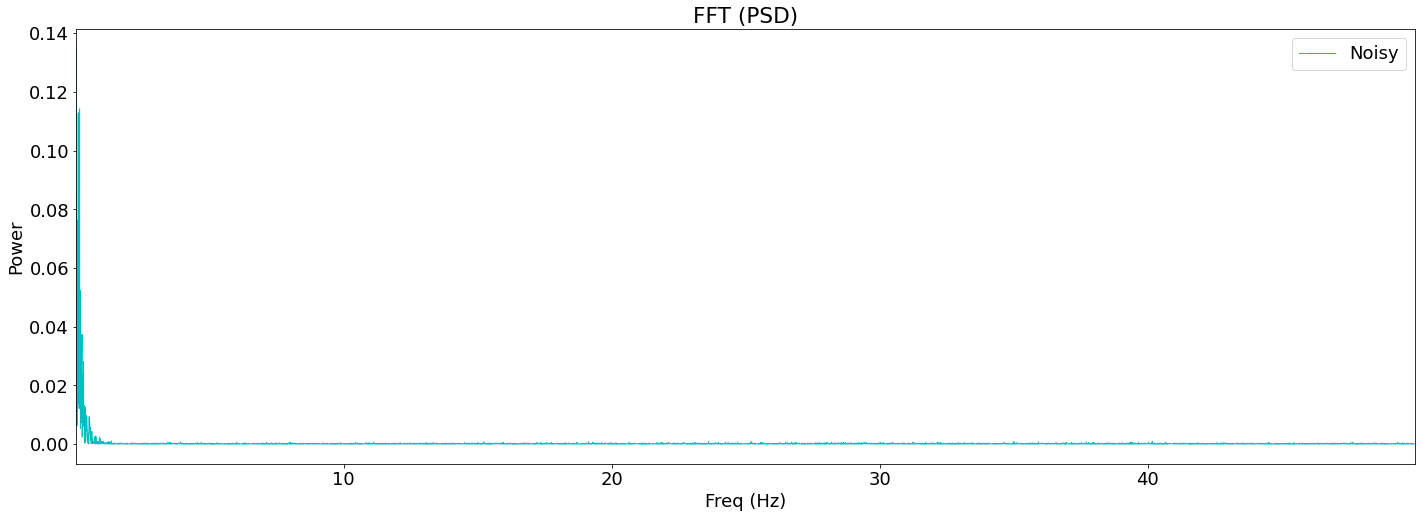

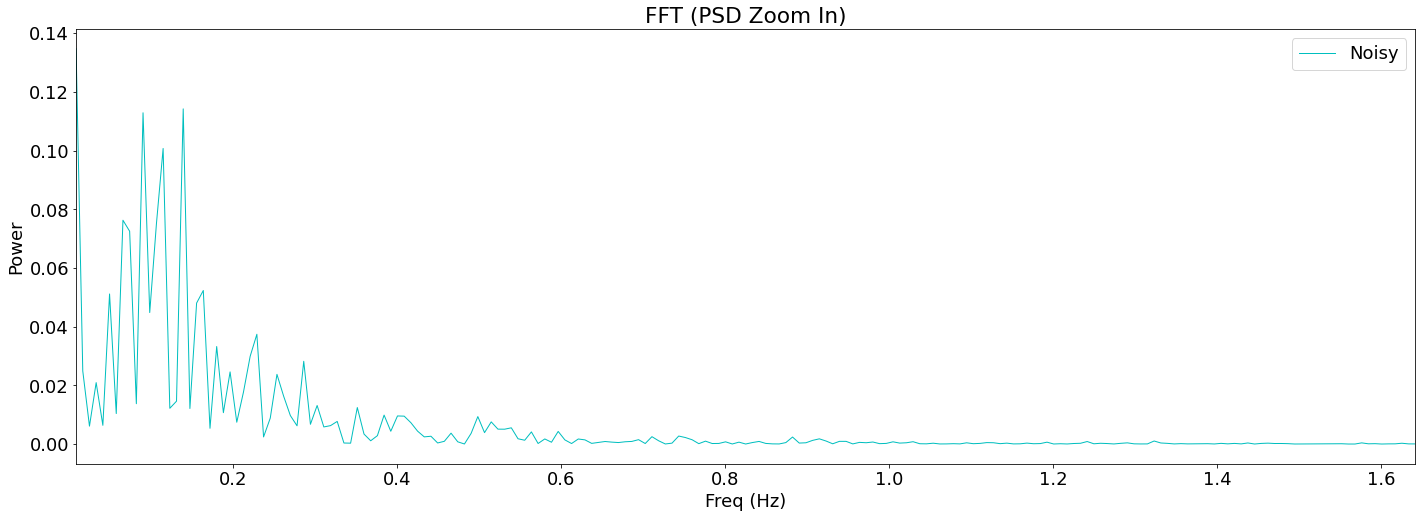

In [ ]:
plt.figure(figsize=(24,8))
plt.plot(freq[L], zPSD[L], color='c', LineWidth=1, label='Noisy')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.xlabel("Freq (Hz)")
plt.ylabel('Power')
plt.title('FFT (PSD)')
plt.legend()
plt.show()

plt.figure(figsize=(24,8))
plt.plot(freq[L], zPSD[L], color='c', LineWidth=1, label='Noisy')
plt.xlim(freq[L[0]], freq[L[200]])
plt.xlabel("Freq (Hz)")
plt.ylabel('Power')
plt.title('FFT (PSD Zoom In)')
plt.legend()
plt.show()


In [ ]:
# Menggunakan High pass filter pada zPSD untuk memfilter Noise
indices = zPSD > 0.03 # Temukan semua Frequency yang power/aplitude yang lebih besar 
zPSDclean = zPSD * indices # Melemahkan Frequency yang dibawah cutoff
zfhat = indices * zfhat # Melemahkan Fourier coeffs yang kecil
ffilt = np.fft.ifft(zfhat) # Inverse FFT untuk filtered time signal

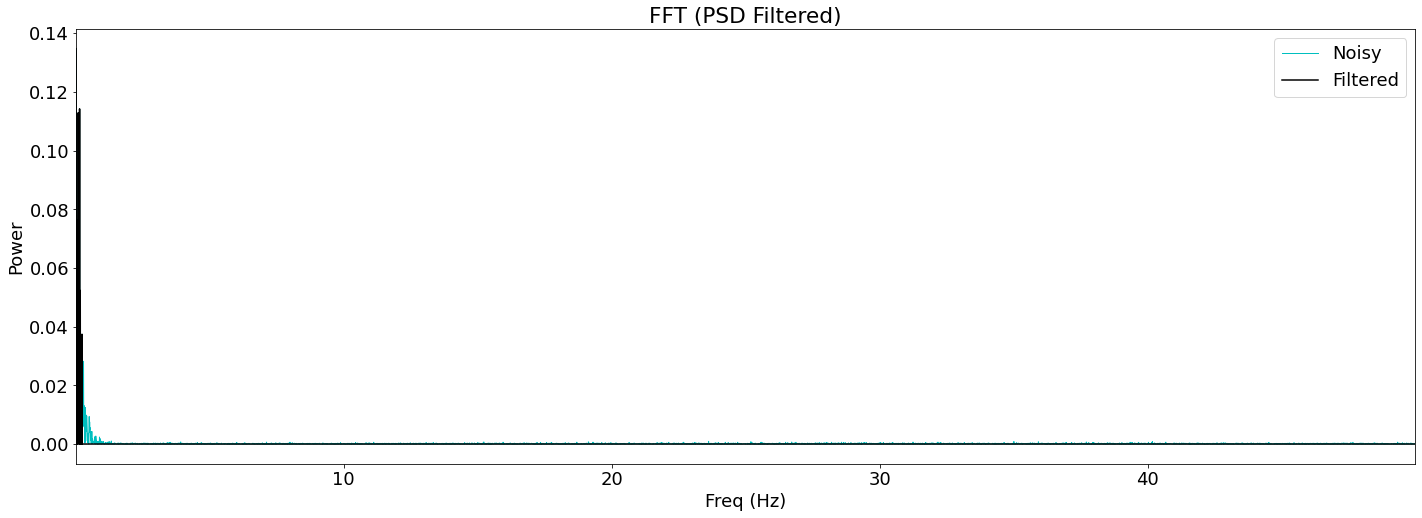

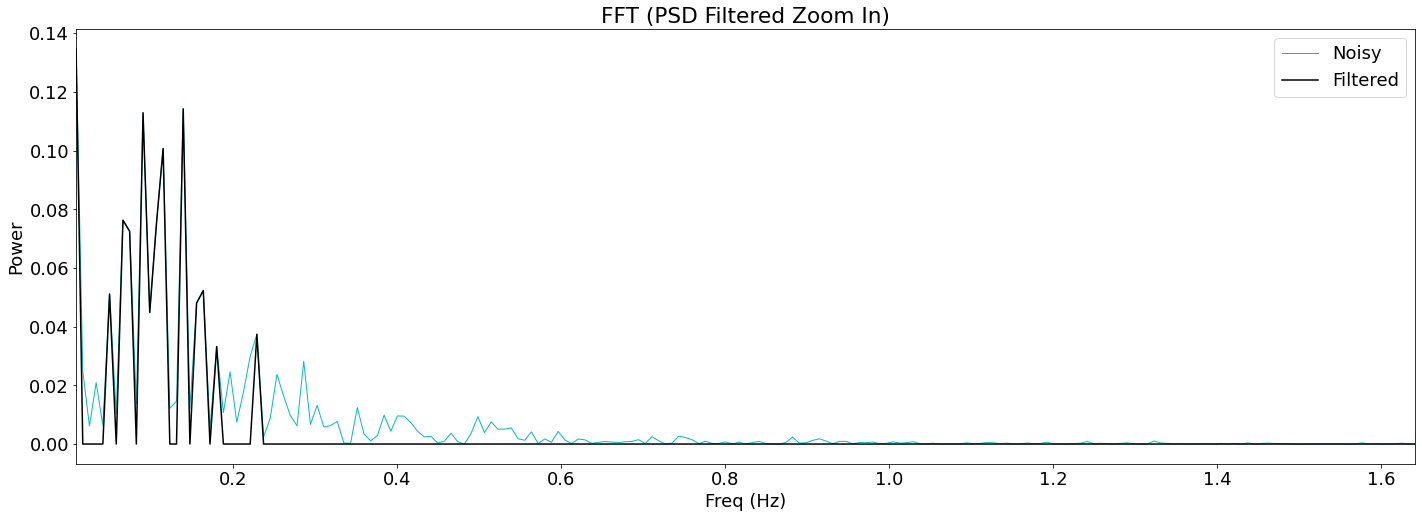

In [ ]:
plt.figure(figsize=(24,8))
plt.plot(freq[L], zPSD[L], color='c', LineWidth=1, label='Noisy')
plt.plot(freq[L], zPSDclean[L], color='k', LineWidth=1.5, label='Filtered')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.xlabel("Freq (Hz)")
plt.ylabel('Power')
plt.title('FFT (PSD Filtered)')
plt.legend()
plt.show()

plt.figure(figsize=(24,8))
plt.plot(freq[L], zPSD[L], color='c', LineWidth=1, label='Noisy')
plt.plot(freq[L], zPSDclean[L], color='k', LineWidth=1.5, label='Filtered')
plt.xlim(freq[L[0]], freq[L[200]])
plt.xlabel("Freq (Hz)")
plt.ylabel('Power')
plt.title('FFT (PSD Filtered Zoom In)')
plt.legend()
plt.show()

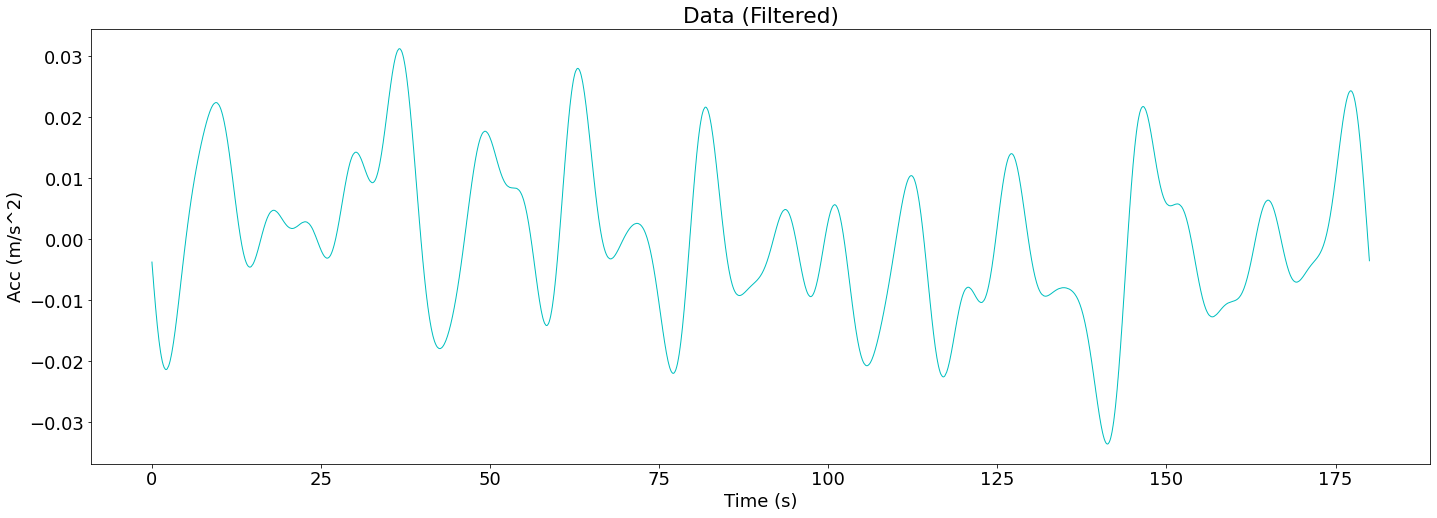

In [ ]:
plt.figure(figsize=(24,8))
plt.plot(data.index, ffilt, color='c', LineWidth=1)
plt.xlabel("Time (s)")
plt.ylabel('Acc (m/s^2)')
plt.title('Data (Filtered)')
plt.show()

In [ ]:
data['Z_Filtered'] = np.real(ffilt)

fig = fig_from_df(data.drop(columns=['Linear_Acceleration_x_(m/s^2)','Linear_Acceleration_y_(m/s^2)']))
fig.write_html('time-history.html',full_html=False,include_plotlyjs='cdn')
fig.update_layout(
    title = "Raw Signal with Filtered Signal",
    xaxis_title = "Time (s)",
    yaxis_title = "Acc (m/s^2)"
)
fig.show()


In [ ]:
def _boolrelextrema(data, comparator, axis=0, order=1, mode='clip'):
    if((int(order) != order) or (order < 1)): #Periksa apakah ORder setidaknya >= 1
        raise ValueError('Order must be an int >= 1')

    datalen = data.shape[axis] # Panjang data
    locs = np.arange(0, datalen) # Membuat Array [0, 1, 2, ... , n]

    results = np.ones(data.shape, dtype=bool) # Membuat Array Boolean samapai n
    main = data.take(locs, axis=axis, mode=mode) # Ambil semua data pada axis
    for shift in range(1, order + 1):
        plus = data.take(locs + shift, axis=axis, mode=mode) # Ambil data dengan offset locs + shift dengan mode clip sebagai default
        minus = data.take(locs - shift, axis=axis, mode=mode) # Ambil data dengan offset locs - shift dengan mode clip sebagai default
        results &= comparator(main, plus) # Membandingkan data main apakah lebih besar dari data plus dan melakukan clipping pada Result
        results &= comparator(main, minus) # Membandingkan data main apakah lebih besar dari data minus dan melakukan clipping pada Result
    return results #return Array of Boolean yang berisikan True jika dia sebiah puncak dan False Jika sebaliknya

def argrelextrema(data, comparator, axis=0, order=1, mode='clip'):
    results = _boolrelextrema(data, comparator,axis, order, mode) # return array of booelan yang berisikan indices puncak
    return np.nonzero(results) # Return indices yang tidak False

In [ ]:
# Mencari puncak menggunakan fungsi argrelexrema yang akan mengembalikan index puncak
y_peak = argrelextrema(data['Z_Filtered'].to_numpy(), np.greater_equal, 0, 2)
# Plotting sinyal filter dengan marker puncak
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = data['Z_Filtered'],
    x = data.index,
    line =  dict(shape =  'spline' ),
    name = 'filtered signal',
))

fig.add_trace(go.Scatter(
        mode='markers',
        y = data.iloc[y_peak].Z_Filtered,
        x = data.iloc[y_peak].index,
        marker=dict(
            color='LightSkyBlue',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        ),
        showlegend=False
    )
)
fig.update_layout(
    title = "Filtered Signal Direct",
    xaxis_title = "Time (s)",
    yaxis_title = "Acc (m/s^2)"
)
fig.show()

In [ ]:
data['Z_Filtered']

Time_(s)
0.031632     -0.003716
0.041642     -0.003932
0.061631     -0.004148
0.071640     -0.004363
0.091629     -0.004577
                ...   
179.947801   -0.002628
179.967790   -0.002847
179.977800   -0.003065
179.997789   -0.003283
180.007799   -0.003500
Name: Z_Filtered, Length: 12242, dtype: float64

In [ ]:
TUPLE_HIGH = [0.015 , 0.02]
TUPLE_MEDIUM = [0.01, 0.015 ,0.02]
TUPLE_LOW = [0.01, 0.015]

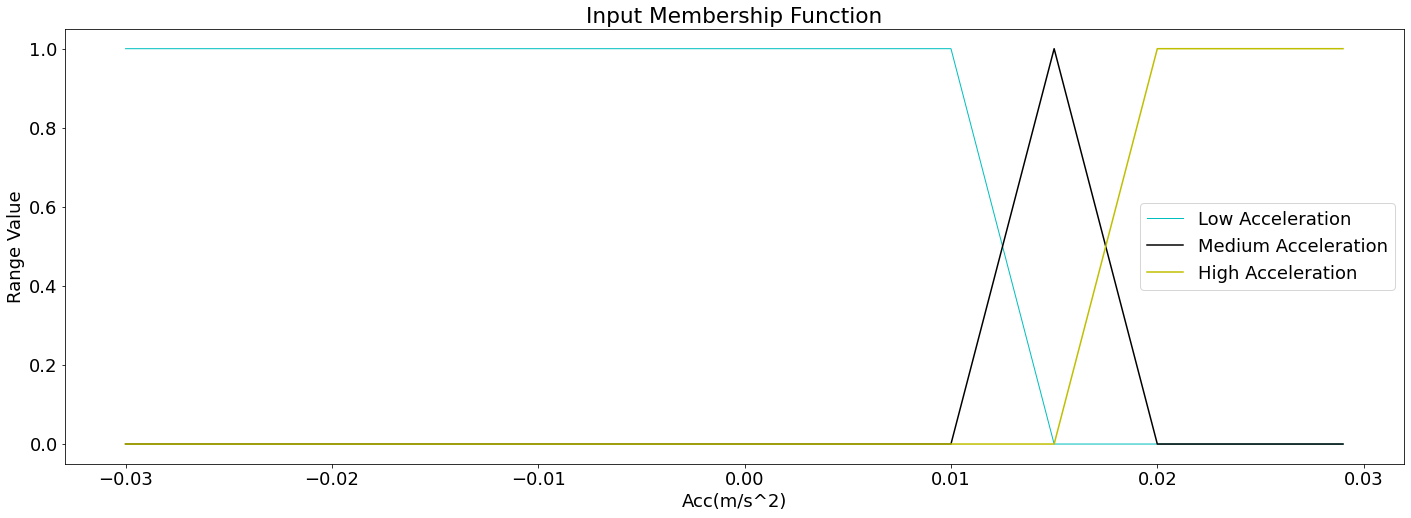

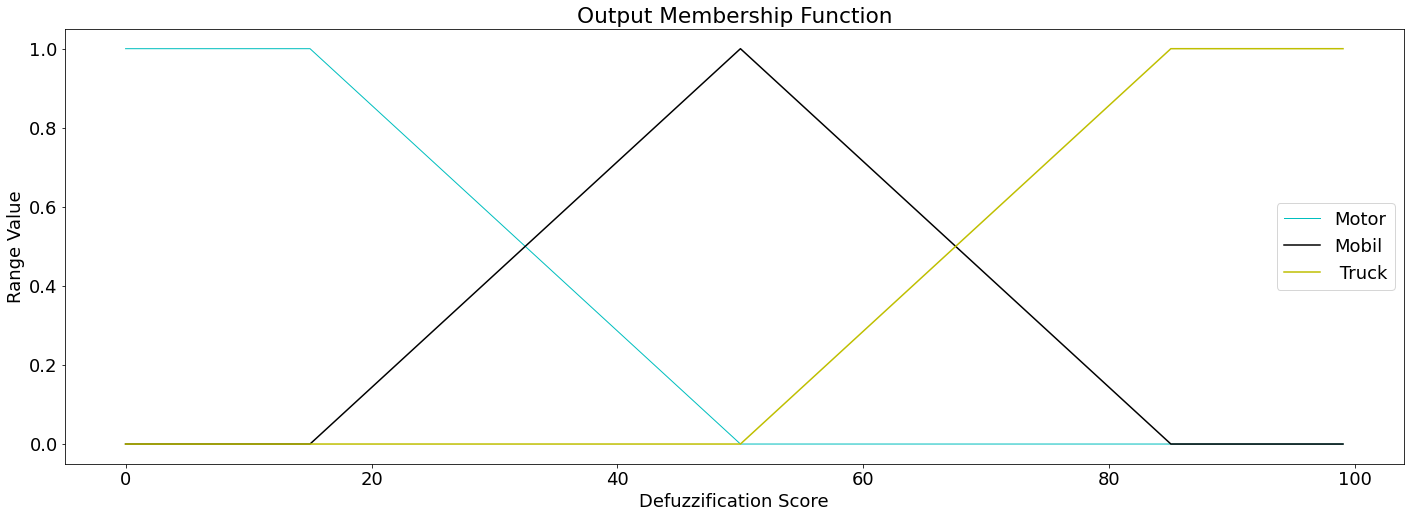

In [ ]:
#Membership Function
def Triangles(x,a,b,c):
  if x <= a or x >= c:
    return 0
  if a < x and x <= b:
    return (x-a)/(b-a)
  return -(x-c)/(c-b)
  
def LinearHigh(x,a,b):
  if x <= a:
    return 0
  if a < x and x <= b:
    return (x-a)/(b-a)
  return 1
  
def LinearLow(x,a,b):
  if x <= a:
    return 1
  if a < x and x <= b:
    return (b-x)/(b-a)
  return 0

def Trapezoidal(x,a,b,c,d):
    if x <= a or x >= d:
      return 0
    if a < x and x < b: 
      return (x-a)/(b-a)
    if b <= x and x <= c:
      return 1
    return -(x-d)/(d-c)

# Domain Membership Input
x_membership = np.arange(-0.03, 0.03, 0.001)
y_value = np.arange(0,1,0.1)
lowAcc = []
for i in range(len(x_membership)):
    lowAcc.append(LinearLow(x_membership[i],TUPLE_LOW[0], TUPLE_LOW[1])) # Membership Low Acceleration
mediumAcc = []
for i in range(len(x_membership)):
    mediumAcc.append(Trapezoidal(x_membership[i],TUPLE_MEDIUM[0], TUPLE_LOW[1], TUPLE_HIGH[0],TUPLE_MEDIUM[2])) # Membership Medium Acceleration
highAcc = []
for i in range(len(x_membership)):
    highAcc.append(LinearHigh(x_membership[i],TUPLE_HIGH[0],TUPLE_HIGH[1])) # Membership high Acceleration

# Plottingan Input Membership Function
plt.figure(figsize=(24,8))
plt.plot(x_membership, lowAcc, color='c', LineWidth=1, label='Low Acceleration')
plt.plot(x_membership, mediumAcc, color='k', LineWidth=1.5, label='Medium Acceleration')
plt.plot(x_membership, highAcc, color='Y', LineWidth=1.5, label='High Acceleration')
plt.xlabel("Acc(m/s^2)")
plt.ylabel('Range Value')
plt.title('Input Membership Function')
plt.legend()
plt.show()

# Domain Membership Output
x_membership = np.arange(0, 100, 1)
y_value = np.arange(0, 1, 0.1)
motor = []
for i in range(len(x_membership)):
    motor.append(LinearLow(x_membership[i], 15, 50)) # Membership Motor
mobil = []
for i in range(len(x_membership)):
    mobil.append(Triangles(x_membership[i],15, 50, 85)) # Membership Mobil
truck = []
for i in range(len(x_membership)):
    truck.append(LinearHigh(x_membership[i],50, 85)) # Membership Truck

# Plottingan Output Membership Function 
plt.figure(figsize=(24,8))
plt.plot(x_membership, motor, color='c', LineWidth=1, label='Motor')
plt.plot(x_membership, mobil, color='k', LineWidth=1.5, label='Mobil')
plt.plot(x_membership, truck, color='Y', LineWidth=1.5, label=' Truck')
plt.xlabel("Defuzzification Score")
plt.ylabel('Range Value')
plt.title('Output Membership Function')
plt.legend()
plt.show()


In [ ]:
class Fuzzy:
  #constructor
  def __init__(self, _index, _data):
    self.index = _index
    self.data = _data
    
    #Fuzzyfication
    self.highAcc = self.LinearHigh(_data, TUPLE_HIGH[0],TUPLE_HIGH[1])
    self.mediumAcc = self.Trapezoidal(_data, TUPLE_MEDIUM[0], TUPLE_LOW[1], TUPLE_HIGH[0],TUPLE_MEDIUM[2])
    self.lowAcc = self.LinearLow(_data, TUPLE_LOW[0], TUPLE_LOW[1])
    
    #Inference
    self.truck = self.TruckRules();
    self.mobil = self.MobilRules();
    self.motor = self.MotorRules();

    #Deffuzzification
    self.score = self.Deffuzzication()

  # Membership Function
  def Triangles(self,x,a,b,c):
    if x <= a or x >= c:
      return 0
    if a < x and x <= b:
      return (x-a)/(b-a)
    return -(x-c)/(c-b)
  
  def LinearHigh(self,x,a,b):
    if x <= a:
      return 0
    if a < x and x <= b:
      return (x-a)/(b-a)
    return 1
  
  def LinearLow(self,x,a,b):
    if x <= a:
      return 1
    if a < x and x <= b:
      return (b-x)/(b-a)
    return 0

  
  def Trapezoidal(self,x,a,b,c,d):
    if x <= a or x >= d:
      return 0
    if a < x and x < b: 
      return (x-a)/(b-a)
    if b <= x and x <= c:
      return 1
    return -(x-d)/(d-c)
  
  # Fuzzy Rules
  def TruckRules(self):
    if self.highAcc == 1:
      return 1
    elif self.highAcc == 0 and self. mediumAcc == 0:
      return 0
    else:
      return max(self.highAcc, self.mediumAcc)

  def MobilRules(self):
    if self.mediumAcc == 1:
      return 1
    elif self.highAcc != 0 and self. mediumAcc != 0:
      return max(self.highAcc, self.mediumAcc)
    elif self.lowAcc != 0 and self. mediumAcc != 0:
      return max(self.lowAcc, self.mediumAcc)
    else:
      return 0

  def MotorRules(self):
    if self.lowAcc == 1:
      return 1
    elif self.lowAcc == 0 and self. mediumAcc == 0:
      return 0
    else:
      return max(self.lowAcc, self.mediumAcc)

  #Deffuzication
  def Deffuzzication(self):
    i = 1
    j = 0
    maxValue = []
    mult = 0

    while i < 100:
      tempMotor = self.LinearLow(i, 15, 50);          #Output Membership Function Motor
      tempMobil = self.Triangles(i,15, 50, 85)        #Output Membership Function Mobil
      tempTruck = self.LinearHigh(i, 50, 85)          #Output Membership Function Truck
      
      maxValue.append(max(self.Clipping(tempMotor, self.motor), self.Clipping(tempMobil, self.mobil), self.Clipping(tempTruck, self.truck)))
      mult += maxValue[j] * i

      i += 1
      j += 1
   
    return mult/sum(maxValue) # Weighted Average
  
  # Clipping Value
  def Clipping(self, value, clip):
    if value >= clip:
      return clip
    else:
      return value

In [ ]:
for i in range(len(y_peak[0])):
  print(round(data.iloc[y_peak[0][i]].Z_Filtered,3))

-0.004
0.022
0.005
0.003
0.014
0.031
0.018
0.028
0.003
0.022
0.005
0.006
0.01
-0.008
0.014
-0.008
0.022
0.006
0.006
0.024


In [ ]:
fuzzy_set = []
count_motor = 0;
count_mobil = 0;
count_truck = 0

# Membuat Fuzzy Set semua nilai puncak dan mengklasifikasikannya berdasarkan nilia Crisp Value
# Jika Score Crisp Value dari Hasil Fuzyy == 15 maka Motor
# Jika Score Crisp Value dari Hasil Fuzyy == 50 maka Mobil
# Jika Score Crisp Value dari Hasil Fuzyy == 85 maka Truck
for i in range(len(y_peak[0])):
  fuzzy_set.append(Fuzzy(i, round(data.iloc[y_peak[0][i]].Z_Filtered, 3)))
  if round(fuzzy_set[i].score) <= 15:
    print("Kendaraan ", i+1 ," Terdeteksi sebagai Motor \t\t( Persentase = ", round(fuzzy_set[i].score/15, 2) ,", Crsip Value = ", round(fuzzy_set[i].score),")")
    count_motor += 1
  elif round(fuzzy_set[i].score) >= 85:
    print("Kendaraan ", i+1 ," Terdeteksi sebagai Truck \t\t( Persentase = ", round(fuzzy_set[i].score/85, 2) ,", Crsip Value =", round(fuzzy_set[i].score), ")")
    count_truck += 1
  elif round(fuzzy_set[i].score) == 50:
    print("Kendaraan ", i+1 ," Terdeteksi sebagai Mobil \t\t( Persentase = ", round(fuzzy_set[i].score/50, 2),", Crsip Value = ", round(fuzzy_set[i].score), ")")
    count_mobil += 1
  elif round(fuzzy_set[i].score) > 50 and round(fuzzy_set[i].score) < 67.5:
    print("Kendaraan ", i+1 ," Terdeteksi sebagai Mobil \t\t( Persentase = ", round(50/fuzzy_set[i].score, 2),", Crsip Value = ", round(fuzzy_set[i].score), ")")
    count_mobil += 1
  elif round(fuzzy_set[i].score) > 50 and round(fuzzy_set[i].score) >= 67.5:
    print("Kendaraan ", i+1, " Terdeteksi sebagai Truck \t\t( Persentase = ", round(fuzzy_set[i].score/85, 2),", Crsip Value = ", round(fuzzy_set[i].score), ")")
    count_truck += 1
  elif round(fuzzy_set[i].score) < 50 and round(fuzzy_set[i].score) >= 32.5:
    print("Kendaraan ", i+1 ," Terdeteksi sebagai Mobil \t\t( Persentase = ", round(fuzzy_set[i].score/50, 2),", Crsip Value = ", round(fuzzy_set[i].score), ")")
    count_mobil += 1
  elif round(fuzzy_set[i].score) < 50 and round(fuzzy_set[i].score) < 32.5:
    print("Kendaraan ", i+1 ," Terdeteksi sebagai Motor \t\t( Persentase = ", round(15/fuzzy_set[i].score, 2),", Crsip Value =", round(fuzzy_set[i].score), ")")
    count_motor += 1
print("===============================================================")
print("Jumlah Motor yang terdeteksi : ", count_motor)
print("Jumlah Mobil yang terdeteksi : ", count_mobil)
print("Jumlah Truck yang terdeteksi : ", count_truck)

Kendaraan  1  Terdeteksi sebagai Motor 		( Persentase =  0.83 , Crsip Value = 18 )
Kendaraan  2  Terdeteksi sebagai Truck 		( Persentase =  0.96 , Crsip Value =  82 )
Kendaraan  3  Terdeteksi sebagai Motor 		( Persentase =  0.83 , Crsip Value = 18 )
Kendaraan  4  Terdeteksi sebagai Motor 		( Persentase =  0.83 , Crsip Value = 18 )
Kendaraan  5  Terdeteksi sebagai Mobil 		( Persentase =  1.0 , Crsip Value =  50 )
Kendaraan  6  Terdeteksi sebagai Truck 		( Persentase =  0.96 , Crsip Value =  82 )
Kendaraan  7  Terdeteksi sebagai Mobil 		( Persentase =  0.93 , Crsip Value =  54 )
Kendaraan  8  Terdeteksi sebagai Truck 		( Persentase =  0.96 , Crsip Value =  82 )
Kendaraan  9  Terdeteksi sebagai Motor 		( Persentase =  0.83 , Crsip Value = 18 )
Kendaraan  10  Terdeteksi sebagai Truck 		( Persentase =  0.96 , Crsip Value =  82 )
Kendaraan  11  Terdeteksi sebagai Motor 		( Persentase =  0.83 , Crsip Value = 18 )
Kendaraan  12  Terdeteksi sebagai Motor 		( Persentase =  0.83 , Crsip Value = 1

---------------------------------

---



In [ ]:
# #filter function
 
# #low pass filter
# def butter_lowpass(cutoff, fs, order):
#   nyq = 0.5 * fs
#   normal_cutoff = cutoff / nyq
#   b, a = butter(order, normal_cutoff, btype='low', analog=False)
#   return b, a
  
# #band pass filter with lfiter
# def butter_lowpass_filter(data, cutoff, fs, order):
#   b, a = butter_lowpass(cutoff, fs, order=order)
#   y = lfilter(b, a, data)
#   return y
 
# def butter_bandpass(lowcut, highcut, fs, order):
#   nyq = 0.5 * fs
#   low = lowcut / nyq
#   high = highcut / nyq
#   b, a = butter(order, [low, high], btype='band')
#   return b, a
 
# #band pass filter with filtfilt
# def butter_bandpass_filter(data, lowcut, highcut, fs, order):
#   b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#   # y = lfilter(b, a, data)
#   y =filtfilt(b, a, data)
#   return y
 
# def butter_bandpass_filter2(data, lowcut, highcut, fs, order):
#   b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#   y = lfilter(b, a, data)
#   # y =filtfilt(b, a, data)
#   return y
 
# #high pass filter
# def butter_highpass(cutoff,fs, order):
#   nyq = 0.5 * fs
#   normal_cutoff = cutoff / nyq
#   b,a = butter(order,normal_cutoff, btype='high', analog=False)
#   return b, a
 
# def butter_highpass_filter(data, cutoff, fs, order):
#   b, a = butter_highpass(cutoff, fs, order=order)
#   y = filtfilt(b,a,data)
#   return y
 

In [ ]:
# fs = 100 #Frekuensi Sample
# cutoff = 0.1
# nyq = 0.5 * fs # Nyquist frequency
# order = 2 #Order

# # highpass pada sudut z
# z_filtered = butter_lowpass_filter(data["Linear_Acceleration_z_(m/s^2)"], cutoff,fs,order)
# # z_filtered = bandpassfilter(data["Linear_Acceleration_x_(m/s^2)"], low_cut, high_cut,fs,order)
# # Menambahkan hasil lowpass pada dataframe data
# data['z_filtered'] = z_filtered

# #Plotting hasil filter sinyal Raw
# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     y = data['Linear_Acceleration_z_(m/s^2)'],
#     x = data.index,
#     line =  dict(shape =  'spline' ),
#     name = 'Signal with noise'
# ))

# fig.add_trace(go.Scatter(
#     y = data['z_filtered'],
#     x = data.index,
#     line =  dict(shape =  'spline' ),
#     name = 'filtered signal'
# ))
# fig.update_layout(
#     title = "Processed Signal",
#     xaxis_title = "Time (s)",
#     yaxis_title = "Acc (m/s^2)"
# )
# fig.show()